In [13]:
import seaborn as sns

In [14]:
import pandas as pd

df = pd.read_csv('C:\\Assign 4\\musicmood-master\\musicmood-master\\dataset\\training\\train_lyrics_1000.csv')

df.head()

,file,artist,title,lyrics,genre,mood,year
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,Verse One:\n\nAlright I might\nHave had a litt...,Hip Hop/Rap,sad,1994
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\nEvery girl is a someth...,Rock,happy,1982
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,Little darling \nWhere you've been so long \nI...,R&B,happy,1986
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,"Lead Vocal by Greg\n\nWell, these late night c...",Rock,sad,1987


In [15]:
# Label Encoder

from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np

X_train = df['lyrics'].values 

y_train = df['mood'].values

print('before: %s ...' %y_train[:5])

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train[:5])

before: ['sad' 'happy' 'sad' 'happy' 'sad'] ...
after: [1 0 1 0 1] ...


In [48]:
# Porter Stemmer

import nltk
import string
import re

porter_stemmer = nltk.stem.porter.PorterStemmer()

def porter_tokenizer(text, stemmer=porter_stemmer):
    """
    A Porter-Stemmer-Tokenizer hybrid to splits sentences into words (tokens) 
    and applies the porter stemming algorithm to each of the obtained token. 
    Tokens that are only consisting of punctuation characters are removed as well.
    Only tokens that consist of more than one letter are being kept.
    
    Parameters
    ----------
        
    text : `str`. 
      A sentence that is to split into words.
        
    Returns
    ----------
    
    no_punct : `str`. 
      A list of tokens after stemming and removing Sentence punctuation patterns.
    
    """
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct

In [17]:
# Printing stop words
with open('C:\\Assign 4\\musicmood-master\\musicmood-master\\code\\classify_lyrics\\stopwords_eng.txt', 'r') as infile:
    stop_words = infile.read().splitlines()
print('stop words %s ...' %stop_words[:5])

stop words ['i', 'me', 'my', 'myself', 'we'] ...


In [18]:
# Count Vectorizer


from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer,
            ngram_range=(1,1)
    )

In [19]:
# Fitting the lyrics
vec = vec.fit(X_train.ravel())

C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [20]:
# TFIDF Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer
    )

In [21]:
# Fitting the lyrics for TFIDF

tfidf = tfidf.fit(X_train.ravel())

print('Vocabulary size: %s' %len(tfidf.get_feature_names()))

C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Vocabulary size: 8550


In [22]:
# Models: Multivariate Bernoulli and Multinomial naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

In [23]:
# Performance metric F1 score

# Custom scorer methods to account for positive-negative class labels

from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)

In [24]:
# Grid Search for best parameters


from sklearn.model_selection import GridSearchCV
from pprint import pprint

pipeline_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', BernoulliNB())
])

parameters_1 = dict(
    vect__binary=[True],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_1 = GridSearchCV(pipeline_1, 
                           parameters_1, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_1.steps])
print("parameters:")
pprint(parameters_1, depth=2)
grid_search_1.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_1.best_score_)
print("Best parameters set:")
best_parameters_1 = grid_search_1.best_estimator_.get_params()
for param_name in sorted(parameters_1.keys()):
    print("\t%s: %r" % (param_name, best_parameters_1[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [True],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [[...], None],
 'vect__tokenizer': [<function porter_tokenizer at 0x000002146AA76EA0>, None]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Y

C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv',

Best score: 0.617
Best parameters set:
	vect__binary: True
	vect__ngram_range: (1, 1)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 

In [25]:
# Grid search best parrameter for combination of CountVectorizer and MultinomialNB

from sklearn.model_selection import GridSearchCV

pipeline_3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

parameters_3 = dict(
    vect__binary=[False],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_3 = GridSearchCV(pipeline_3, 
                           parameters_3, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_3.steps])
print("parameters:")
pprint(parameters_3, depth=2)
grid_search_3.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_3.best_score_)
print("Best parameters set:")
best_parameters_3 = grid_search_3.best_estimator_.get_params()
for param_name in sorted(parameters_3.keys()):
    print("\t%s: %r" % (param_name, best_parameters_3[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [False],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [[...], None],
 'vect__tokenizer': [<function porter_tokenizer at 0x000002146AA76EA0>, None]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Y

C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop w

Best score: 0.620
Best parameters set:
	vect__binary: False
	vect__ngram_range: (1, 1)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',

In [26]:
# Grid search best parrameter for combination of TfidfVectorizer and MultinomialNB

from sklearn.model_selection import GridSearchCV

pipeline_4 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

parameters_4 = dict(
    vect__binary=[False],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_4 = GridSearchCV(pipeline_4, 
                           parameters_4, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_4.steps])
print("parameters:")
pprint(parameters_4, depth=2)
grid_search_4.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_4.best_score_)
print("Best parameters set:")
best_parameters_4 = grid_search_4.best_estimator_.get_params()
for param_name in sorted(parameters_4.keys()):
    print("\t%s: %r" % (param_name, best_parameters_4[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [False],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [[...], None],
 'vect__tokenizer': [<function porter_tokenizer at 0x000002146AA76EA0>, None]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Y

C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop w

Best score: 0.335
Best parameters set:
	vect__binary: False
	vect__ngram_range: (2, 2)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',

C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop w

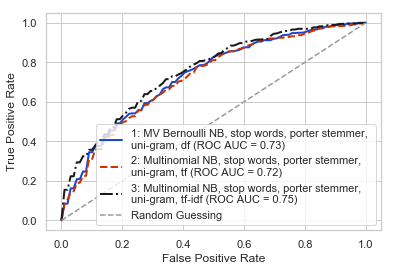

In [49]:
# Grid Search ROC curves

from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")

clf_1 = Pipeline([
                  ('vect', CountVectorizer(
                                           binary=True,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', BernoulliNB()),
                 ])

clf_2 = Pipeline([
                  ('vect', CountVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', MultinomialNB()),
                 ])

clf_3 = Pipeline([
                  ('vect', TfidfVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', MultinomialNB()),
                 ])

colors = ['#1947D1', '#CC3300', 'k']
linestyles = ['-', '--', '-.']
classifiers = [clf_1, clf_2, clf_3]
labels = ['1: MV Bernoulli NB, stop words, porter stemmer, \nuni-gram, df', 
          '2: Multinomial NB, stop words, porter stemmer, \nuni-gram, tf',
          '3: Multinomial NB, stop words, porter stemmer, \nuni-gram, tf-idf',
          ]

for clf,col,ls,lab in zip(classifiers, colors, linestyles, labels):
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    mean = []
    cv = StratifiedKFold(n_splits=10, random_state=None, shuffle = False)

    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
       # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean.append(interp(mean_fpr, fpr, tpr))
        mean[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr = np.mean(mean, axis = 0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr,
            mean_tpr,
            color=col,
            linestyle=ls,
            label='%s (ROC AUC = %0.2f)' % (lab, mean_auc),
            lw=2
     )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop w

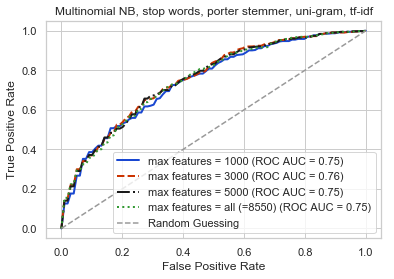

In [51]:
# Hyper parameter tuning max_features

from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', '#339933']
linestyles = ['-', '--', '-.', ':']
params = [1000,3000,5000,None]
labels = ['max features = 1000', 
          'max features = 3000',
          'max features = 5000',
          'max features = all (=8550)',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=porter_tokenizer,
                                                  ngram_range=(1,1),
                                                  max_features=param,
                                                  )
                          ),
                         ('clf', MultinomialNB()),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    mean = []
    cv = StratifiedKFold(n_splits=10, random_state=None, shuffle = False)

    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
       # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean.append(interp(mean_fpr, fpr, tpr))
        mean[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr = np.mean(mean, axis = 0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr,
            mean_tpr,
            color=col,
            linestyle=ls,
            label='%s (ROC AUC = %0.2f)' % (lab, mean_auc),
            lw=2
     )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.legend(loc="lower right")
plt.show()

C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop w

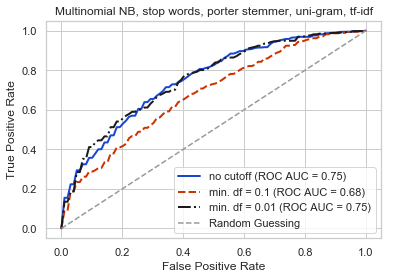

In [52]:
# Hyperparameter tuning 2 - min_df

from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', ]
linestyles = ['-', '--', '-.']
params = [1, 0.1, 0.01]
labels = ['no cutoff',
          'min. df = 0.1', 
          'min. df = 0.01',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=porter_tokenizer,
                                                  ngram_range=(1,1),
                                                  min_df=param,
                                                  )
                          ),
                         ('clf', MultinomialNB()),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    mean = []
    cv = StratifiedKFold(n_splits=10, random_state=None, shuffle = False)

    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
       # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean.append(interp(mean_fpr, fpr, tpr))
        mean[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr = np.mean(mean, axis = 0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr,
            mean_tpr,
            color=col,
            linestyle=ls,
            label='%s (ROC AUC = %0.2f)' % (lab, mean_auc),
            lw=2
     )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.show()

C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\Yash Lekhwani\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop w

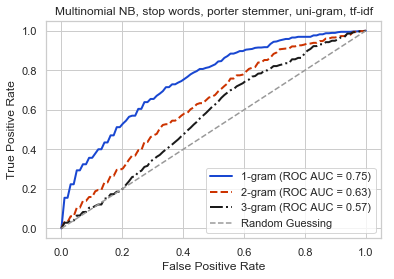

In [53]:
# n-gram comparisons

from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")


colors = ['#1947D1', '#CC3300', 'k', ]
linestyles = ['-', '--', '-.',]
params = [(1,1), (2,2), (3,3),]
labels = ['1-gram', 
          '2-gram',
          '3-gram',
          ]

for param,col,ls,lab in zip(params, colors, linestyles, labels):

    clf = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=porter_tokenizer,
                                                  ngram_range=param,
                                                  
                                                  )
                          ),
                         ('clf', MultinomialNB(alpha=1.0)),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    mean = []
    cv = StratifiedKFold(n_splits=10, random_state=None, shuffle = False)

    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
       # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean.append(interp(mean_fpr, fpr, tpr))
        mean[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr = np.mean(mean, axis = 0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr,
            mean_tpr,
            color=col,
            linestyle=ls,
            label='%s (ROC AUC = %0.2f)' % (lab, mean_auc),
            lw=2
     )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Multinomial NB, stop words, porter stemmer, uni-gram, tf-idf')
plt.show()

In [66]:
# Validation
from sklearn.feature_extraction.text import TfidfVectorizer
final_clf = Pipeline([
                ('vect', TfidfVectorizer(
                                         binary=False,
                                         stop_words=stop_words,
                                         #tokenizer=porter_tokenizer,
                                         ngram_range=(1,1),
                                         )
                ),
                ('clf', MultinomialNB(alpha=1.0)),
               ])
final_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [67]:
import matplotlib.pyplot as plt

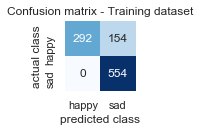

In [68]:
import matplotlib as mpl
import numpy as np

cm = metrics.confusion_matrix(y_train, final_clf.predict(X_train))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Training dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
# plt.savefig('./images/confmat_training.eps', dpi=300)
plt.show()

In [69]:
# Confusion matrix with validation set

df = pd.read_csv('C:\\Assign 4\\musicmood-master\\musicmood-master\\dataset\\validation\\valid_lyrics_200.csv')

X_valid = df['lyrics'].values 
y_valid = df['mood'].values

y_valid = le.transform(y_valid)

In [76]:
print(type(X_valid))

<class 'numpy.ndarray'>


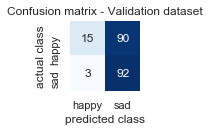

In [70]:
cm = metrics.confusion_matrix(y_valid, final_clf.predict(X_valid))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Validation dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
# plt.savefig('./images/confmat_valid.eps', dpi=300)
plt.show()

In [71]:
# Custom scorer methods to account for positive-negative class labels

from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

acc_scorer = metrics.make_scorer(metrics.accuracy_score, greater_is_better=True)
pre_scorer = metrics.make_scorer(metrics.precision_score, greater_is_better=True, pos_label=0)
rec_scorer = metrics.make_scorer(metrics.recall_score, greater_is_better=True, pos_label=0)
f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)
auc_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True)

In [72]:

d = {'Data':['Training', 'Validation'],
     'ACC (%)':[],
     'PRE (%)':[],
     'REC (%)':[],
     'F1 (%)':[],
     'ROC AUC (%)':[],
}

In [73]:
d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_train, y_true=y_train))

d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))

In [74]:
df_perform = pd.DataFrame(d)
df_perform = df_perform[['ACC (%)', 'PRE (%)', 'REC (%)', 'F1 (%)', 'ROC AUC (%)']]
df_perform.index=(['Training', 'Validation'])
df_perform = df_perform*100
df_perform = np.round(df_perform, decimals=2)
df_perform

,ACC (%),PRE (%),REC (%),F1 (%),ROC AUC (%)
Training,84.6,100.00,65.47,79.13,82.74
Validation,53.5,83.33,14.29,24.39,55.56


In [75]:
lyrics_clf_1000 = final_clf

pickle_out = open('./lyrics_clf_1000_py27.pkl', 'wb')
pickle.dump(lyrics_clf_1000, pickle_out)
pickle_out.close()

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf_pickle, 'NB_final_clf_model.pkl')